In [4]:
import pandas as pd
import utilssphering
import utils
import os
import random

random.seed(9000)

In [6]:
# Set some variables + read the metadata

n_samples = 1000
n_replicates = 4  #number of sample replicates within each plate 
metadata_common = 'Metadata_moa'
metadata_perturbation = 'Metadata_broad_sample'
group_by_feature = 'Metadata_broad_sample'

experiment_df = (
    pd.read_csv('output/experiment-metadata.tsv', sep='\t')
#    .query('Batch==@batch')
)


In [24]:
# Original percentage calculations, without sphering

corr_replicating_df = pd.DataFrame()
corr_matching_df = pd.DataFrame()

for a_vendor in experiment_df["Vendor"].unique():
    vendor_data = experiment_df.loc[experiment_df["Vendor"] == a_vendor]
#    print([a_vendor, len(vendor_data)])
    for a_batch in vendor_data["Batch"].unique():
        batch_data = vendor_data.loc[vendor_data["Batch"] == a_batch]
#        print([a_batch, len(batch_data)])
        for a_plate in batch_data["Assay_Plate_Barcode"].unique():
            plate_data = batch_data.loc[batch_data["Assay_Plate_Barcode"] == a_plate]
#            print([a_plate, len(plate_data)])
            plate_df = utils.load_data(a_batch, a_plate, "normalized_feature_select_negcon_batch.csv.gz")
            plate_df = utils.remove_negcon_empty_wells(plate_df)
                
            replicating_corr = list(utils.corr_between_replicates(plate_df, group_by_feature))
            null_replicating = list(utils.corr_between_non_replicates(plate_df, n_samples=n_samples, n_replicates=n_replicates, metadata_compound_name = group_by_feature))

            prop_95_replicating, value_95_replicating = utils.percent_score(null_replicating, replicating_corr, how='right')
            
            corr_replicating_df = corr_replicating_df.append({'Vendor': a_vendor,
                                                              'Batch': a_batch,
                                                              'Assay_Plate_Barcode': a_plate,
                                                              'Replicating':replicating_corr,
                                                              'Null_Replicating':null_replicating,
                                                              'Percent_Replicating':'%.1f'%prop_95_replicating,
                                                              'Value_95':value_95_replicating}, ignore_index=True)
            
            matching_corr = list(utils.corr_between_perturbation_pairs(plate_df, 'Metadata_moa', 'Metadata_broad_sample'))
            null_matching = list(utils.corr_between_perturbation_non_pairs(plate_df, n_samples=n_samples, metadata_common=metadata_common, metadata_perturbation=metadata_perturbation))

            prop_95_matching, value_95_matching = utils.percent_score(null_matching, matching_corr, how='right')

            corr_matching_df = corr_matching_df.append({'Vendor': a_vendor,
                                                        'Batch': a_batch,
                                                        'Assay_Plate_Barcode': a_plate,
                                                        'Matching':matching_corr,
                                                        'Null_Matching':null_matching,
                                                        'Percent_Matching':'%.3f'%prop_95_matching,
                                                        'Value_95':value_95_matching}, ignore_index=True)

/var/folders/rw/691cc6h16f9cfxlh9g6bpq400000gq/T/ipykernel_12434/1040386038.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_replicating_df = corr_replicating_df.append({'Vendor': a_vendor,
/var/folders/rw/691cc6h16f9cfxlh9g6bpq400000gq/T/ipykernel_12434/1040386038.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_matching_df = corr_matching_df.append({'Vendor': a_vendor,
/var/folders/rw/691cc6h16f9cfxlh9g6bpq400000gq/T/ipykernel_12434/1040386038.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_replicating_df = corr_replicating_df.append({'Vendor': a_vendor,
/var/folders/rw/691cc6h16f9cfxlh9g6bpq400000gq/T/ipykernel_12434/1040386038.py:36: FutureWarning: The frame.append method is deprecated and wi

In [25]:
# Reload any changes in packages (eg. utilssphering)
%load_ext autoreload
%autoreload 2

### Adding sphering
corr_replicating_df_sphere = pd.DataFrame()
corr_matching_df_sphere = pd.DataFrame()

for a_vendor in experiment_df["Vendor"].unique():
    vendor_data = experiment_df.loc[experiment_df["Vendor"] == a_vendor]
    for a_batch in vendor_data["Batch"].unique():
        batch_data = vendor_data.loc[vendor_data["Batch"] == a_batch]
        for a_plate in batch_data["Assay_Plate_Barcode"].unique():
            plate_data = batch_data.loc[batch_data["Assay_Plate_Barcode"] == a_plate]
            data_path = os.path.join("../jump-scope/profiles/", a_batch, a_plate, a_plate+"_normalized_feature_select_negcon_batch.csv.gz")
            load_data = pd.read_csv(data_path)

            # This works
            replicate_corr, null_corr, prop_95, value_95_replicating = utilssphering.calculate_percent_replicating_MOA("", "", data_df=load_data)

            matching_corr, matching_null_cor, prop_95_matching, value_95_matching = utilssphering.calculate_percent_matching_MOA("", "", data_df=load_data)
            
            corr_replicating_df_sphere = corr_replicating_df_sphere.append({'Vendor': a_vendor,
                                                              'Batch': a_batch,
                                                              'Assay_Plate_Barcode': a_plate,
                                                              'Replicating':replicate_corr,
                                                              'Null_Replicating':null_corr,
                                                              'Percent_Replicating':'%.1f'%prop_95,
                                                              'Value_95':value_95_replicating}, ignore_index=True)

            corr_matching_df_sphere = corr_matching_df_sphere.append({'Vendor': a_vendor,
                                                        'Batch': a_batch,
                                                        'Assay_Plate_Barcode': a_plate,
                                                        'Matching':matching_corr,
                                                        'Null_Matching':matching_null_cor,
                                                        'Percent_Matching':'%.3f'%prop_95_matching,
                                                        'Value_95':value_95_matching}, ignore_index=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/rw/691cc6h16f9cfxlh9g6bpq400000gq/T/ipykernel_12434/2842621758.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_replicating_df_sphere = corr_replicating_df_sphere.append({'Vendor': a_vendor,
/var/folders/rw/691cc6h16f9cfxlh9g6bpq400000gq/T/ipykernel_12434/2842621758.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_matching_df_sphere = corr_matching_df_sphere.append({'Vendor': a_vendor,
/var/folders/rw/691cc6h16f9cfxlh9g6bpq400000gq/T/ipykernel_12434/2842621758.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_replicating_df_sphere = corr_replicating_df_sphere.append({'Vendor': a_vendor,
/var/folders/rw/691cc6h16f9cfxlh9g6bpq400000gq/T/ipykernel_12434/2842621758.py:31: FutureWarning: Th

In [33]:
experiment_df

,Vendor,Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,Binning,Magnification,Number_of_channels,Images_per_well,z_plane,BF_Zplanes,Anomaly
0,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Confocal,1,10,6,4,1,NaN,none
1,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,1,10,6,4,1,NaN,none
2,MolDev,Scope1_MolDev_10X_4siteZ,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crestz,Confocal,1,10,6,4,3,NaN,none
3,MolDev,Scope1_MolDev_20X_4site,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_20XPA_Crestz,Confocal,1,20,6,4,3,NaN,none
4,MolDev,Scope1_MolDev_20X_9site,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_9site_20XPA,Confocal,1,20,6,9,1,NaN,none
5,MolDev,Scope1_MolDev_20X_9site,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_9site_20XPA_Crest,Confocal,1,20,6,9,1,NaN,none
6,MolDev,Scope1_MolDev_20X_Adaptive,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_Adaptive_20XPA,Confocal,1,20,6,3,1,NaN,none
7,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,10,4,1,1,NaN,none
8,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117061a10x,Widefield,1,10,4,1,1,NaN,none
9,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117062a10x,Widefield,1,10,4,1,1,NaN,none


In [30]:
# Merge 
# Set column names to take forward
columns = ['Vendor', 'Batch', 'Assay_Plate_Barcode']

# Rename columns to specify which results are sphered, or not
corr_replicating_df.rename(columns = {"Percent_Replicating": "Percent_Replicating_No_Sphere"}, inplace=True)
corr_matching_df.rename(columns = {"Percent_Matching": "Percent_Matching_No_Sphere"}, inplace=True)
corr_replicating_df_sphere.rename(columns = {"Percent_Replicating": "Percent_Replicating_Sphere"}, inplace=True)
corr_matching_df_sphere.rename(columns = {"Percent_Matching": "Percent_Matching_Sphere"}, inplace=True)

# Create a copy of the df to take forward 
_corr_replicating_df = corr_replicating_df[columns+['Percent_Replicating_No_Sphere']].copy()
_corr_matching_df = corr_matching_df[columns+['Percent_Matching_No_Sphere']].copy()
_corr_replicating_df_sphere = corr_replicating_df_sphere[columns+['Percent_Replicating_Sphere']].copy()
_corr_matching_df_sphere = corr_matching_df_sphere[columns+['Percent_Matching_Sphere']].copy()


# _corr_replicating_df is the df for everything to be merged to
rep_match_sphere_df = _corr_replicating_df.copy()

# Merge df on the aforementioned columns. Should be 100% row match
rep_match_sphere_df = rep_match_sphere_df.merge(
    _corr_matching_df, how="inner", on=columns).merge(
        _corr_replicating_df_sphere, how="inner", on=columns).merge(
            _corr_matching_df_sphere, how="inner", on=columns)

all_merge_df = pd.merge(
    rep_match_sphere_df, 
    experiment_df, 
    on = columns, 
    # left_on = ['Scope_vendor','Batch','Plate_Name'], 
    # right_on = ['Vendor','Batch','Assay_Plate_Barcode']
    )

# Save the df
rep_match_sphere_df.to_csv("replicating-matching-sphering.csv", index=False)
all_merge_df.to_csv("replicating-matching-sphering-with-modality-info.csv", index=False)

In [ ]:
# Subset a batch

rep_match_sphere_df.loc[rep_match_sphere_df["Batch"] == "Scope1_MolDev_10X"]


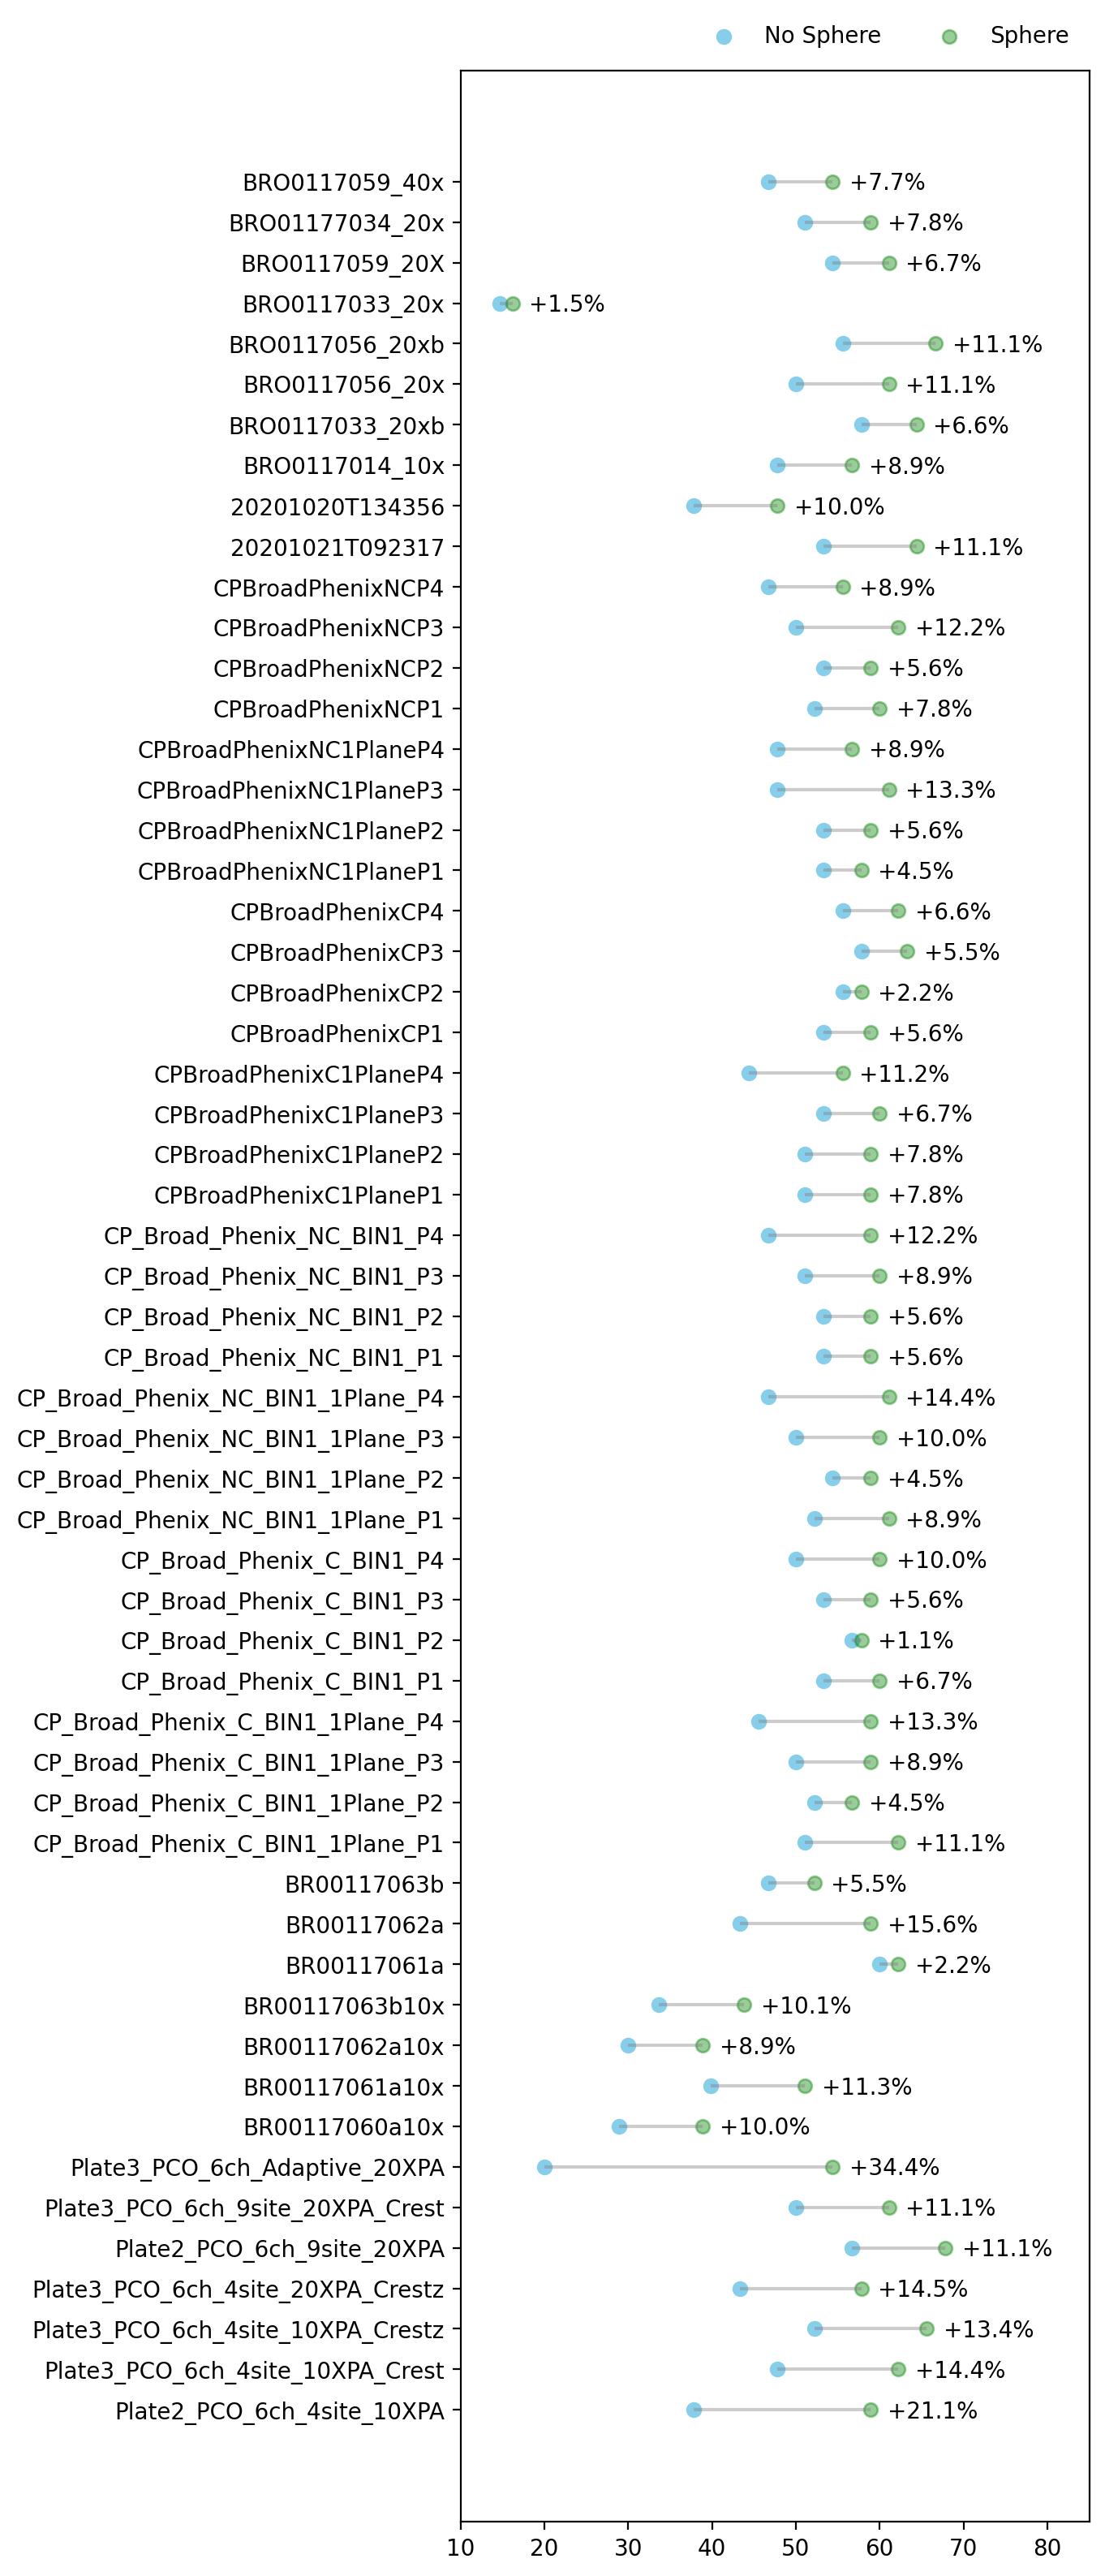

In [32]:
# Dumbell plot the results to compare sphering

import pandas as pd
import matplotlib.pyplot as plt

rep_match_sphere_df = pd.read_csv("replicating-matching-sphering.csv")

fig, ax = plt.subplots(figsize=(5, 20), dpi=200)

df_len = rep_match_sphere_df.shape[0]

ax.set_xlim([10, 85])
ax.hlines(rep_match_sphere_df["Assay_Plate_Barcode"], 
        xmin=rep_match_sphere_df["Percent_Replicating_No_Sphere"].astype(float), 
        xmax=rep_match_sphere_df["Percent_Replicating_Sphere"].astype(float),
        color='grey', alpha=0.4)
ax.scatter(rep_match_sphere_df["Percent_Replicating_No_Sphere"].astype(float),
        rep_match_sphere_df["Assay_Plate_Barcode"],
        color='skyblue', alpha=1,
        label="No Sphere")
ax.scatter(rep_match_sphere_df["Percent_Replicating_Sphere"].astype(float),
        rep_match_sphere_df["Assay_Plate_Barcode"],
        color='green', alpha=0.4,
        label="Sphere")
for (_, row), y in zip(rep_match_sphere_df.iterrows(), range(0, df_len+1)):
        plt.annotate(f"+{row['Percent_Replicating_Sphere'] - row['Percent_Replicating_No_Sphere']:.1f}%", (max(row["Percent_Replicating_No_Sphere"], row["Percent_Replicating_Sphere"])+2, y - 0.2))
ax.legend(ncol=2, bbox_to_anchor=(1, 1.001), loc="lower right", frameon=False)
fig.set_facecolor("white")

fig.savefig("have_no_sphere.png", bbox_inches = 'tight')